#

This notebook collect information for the paper ***Promises and Perils of minining releases on Git***

# Imports

In [4]:
import datetime
import json

## Data Analysis

In [5]:
# %matplotlib inline
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
pd.options.display.max_rows = 1000

from scipy.stats import wilcoxon
from scipy.stats import ranksums

##  Releasy development version

In [6]:
import os
import sys

releasy_module = os.path.abspath(os.path.join('..','..','..','dev','releasy'))
if releasy_module not in sys.path:
    sys.path.insert(0, releasy_module)

In [7]:
for mod in sorted(sys.modules.keys()):
    if mod.startswith("releasy"):
        del sys.modules[mod]

In [8]:
from releasy.miner.vcs.miner import Miner
from releasy.miner.vcs.git import GitVcs

In [9]:
from releasy.miner.vcs import miner as releasy_miner
from releasy.miner.vcs import git as releasy_git

In [10]:
import releasy

In [11]:
import importlib
importlib.reload(releasy_miner)
importlib.reload(releasy_git)

<module 'releasy.miner.vcs.git' from '/home/felipecrp/dev/releasy/releasy/miner/vcs/git.py'>

# Dataset setup

## Variables

In [12]:
repo_path = os.path.join('..','..','..','repos')

In [13]:
projects = pd.read_pickle("projects.zip")
projects["data"] = None

### Mining projects using Releasy

  - Currently, the **track_base_release** param has some performance issues. So to enable rapid mining, it is recommended to disable this param.
  
```{python}
params = {
    "track_base_release": False
}
```

In [51]:
release_prefixes = {
    "angular/angular": [""],
    "nodejs/node": ["v"],
    "git/git": ["v"],
    "microsoft/vscode": ["","v"],
    "ansible/ansible": ["","v"],
    "antirez/redis": ["","v"],
    "aspnet/AspNetCore": ["","v"],
    "bcit-ci/CodeIgniter": ["","v"],
    "prometheus/prometheus": ["","v"],
    "psf/requests": ["","v"],
    "facebook/react": ["","v"],
    "guzzle/guzzle": ["","v"],
    "ionic-team/ionic": ["","v"],
    "Wox-launcher/Wox": ["","v"],
    "FortAwesome/Font-Awesome": ["","v"],
    "microsoft/terminal": ["","v"],
    "blueimp/jQuery-File-Upload": ["","v"],
    "ReactiveX/RxJava": ["","v"],
    "PHPMailer/PHPMailer": ["v"],
    "scrapy/scrapy": ["scrapy-",""],
    "square/okhttp": ["parent-",""],   
    "square/retrofit": ["parent-",""],
    "x64dbg/x64dbg": ["","V"], # only pre releases ALPHA
    "FFmpeg/FFmpeg": ["v","ffmpeg-",":"],
    "angular/angular.js": ["v"],
    "bilibili/ijkplayer": ["n","wk","k"],
    "dotnet-architecture/eShopOnContainers": ["netcore","","v"],
    "dotnet/aspnetcore": ["v",""],
    "zeit/hyper": ["v",""],
    "grafana/grafana": ["v"], # bug -> v5.,
    "golang/go": ["release.r","go"],
    "dotnet/roslyn": ["version-"],
    "facebook/create-react-app": ["v"],
    "fastlane/fastlane": [""],
    "google/guava": ["v"],
    "jekyll/jekyll": ["v"],
    "moby/moby": ["","v"],
    "php/php-src": ["php-","PHP-"],
    "scikit-learn/scikit-learn": [""],
    "tensorflow/tensorflow": ["","v"]
}
release_mine_params = {}
for name in release_prefixes:
    release_mine_params[name] = { "release_prefixes": release_prefixes[name] }


In [53]:
count = 1
projects["data"] = None
for name, project in projects[(projects.data.isnull())].iterrows():
    print(f"{datetime.datetime.now()} - {count:3} - Processing {name}")
    project_group, project_name = name.split("/") 
    path = os.path.join(repo_path, project_group, f"{project_name}.git")
    projects.loc[name, "path"] = path    
    
    mine_params = {
        "track_base_release": False
    }
    if name in release_mine_params:
        mine_params.update(release_mine_params[name])
    
    miner = releasy_miner.Miner(name=name,vcs=releasy_git.GitVcs(path), **mine_params)
    project = miner.mine_commits()
    projects.loc[name, "data"] = project
    count += 1
print(f"{datetime.datetime.now()} - Ended")

2020-01-11 13:50:29.633525 -   1 - Processing freeCodeCamp/freeCodeCamp
2020-01-11 13:50:29.634662 -   2 - Processing facebook/react
2020-01-11 13:50:29.941908 -   3 - Processing twbs/bootstrap
2020-01-11 13:50:30.356676 -   4 - Processing facebook/create-react-app
2020-01-11 13:50:30.413769 -   5 - Processing axios/axios
2020-01-11 13:50:30.435333 -   6 - Processing FortAwesome/Font-Awesome
2020-01-11 13:50:30.460638 -   7 - Processing angular/angular.js
2020-01-11 13:50:30.697836 -   8 - Processing webpack/webpack
2020-01-11 13:50:30.910898 -   9 - Processing hakimel/reveal.js
2020-01-11 13:50:30.962379 -  10 - Processing socketio/socket.io
2020-01-11 13:50:31.008969 -  11 - Processing microsoft/vscode
2020-01-11 13:50:32.126447 -  12 - Processing microsoft/TypeScript
2020-01-11 13:50:32.870646 -  13 - Processing angular/angular
2020-01-11 13:50:33.209202 -  14 - Processing ant-design/ant-design
2020-01-11 13:50:33.509660 -  15 - Processing reduxjs/redux
2020-01-11 13:50:33.575781 - 

## Projects dataset

In [49]:
projects["num_releases"] = projects["data"].apply(lambda p : len(p.releases))
projects["num_tags"] = projects["data"].apply(lambda p : len(p.tags))
projects["per_releases"] = projects["num_releases"] / projects["num_tags"]
projects.loc[projects["num_tags"] == 0, "per_releases"] = 0

In [32]:
projects.shape

(100, 14)

## Tags dataset

In [33]:
tags = []
for project in projects["data"]:
    for tag in project.tags:
        tag = {
            "project": project.name,
            "name": tag.name,
            "data": tag
        }
        tags.append(tag)
tags = pd.DataFrame(tags)
tags.set_index(["project", "name"], inplace=True)

In [34]:
tags["annotated"] = tags["data"].apply(lambda t: t.is_annotated)

## Releases dataset

In [35]:
releases = []
for project in projects["data"]:#.apply(lambda project: project):
    for release in project.releases:
        releases.append({
            "project": project.name,
            "name": release.name,
            "data": release
        })
releases = pd.DataFrame(releases)
releases.set_index(["project","name"], inplace=True)

In [36]:
releases["prefix"] = releases["data"].apply(lambda r: r.prefix)
releases["head_commit"] = releases["data"].apply(lambda r: r.head_commit.hashcode)

releases["time"] = releases["data"].apply(lambda r: r.get_time())
releases["start_development"] = releases["data"].apply(lambda r: r.get_time(of=releasy.START_DEVELOPMENT_TIME))
releases["length"] = releases["data"].apply(lambda r: r.get_length())
# releases.loc[releases["length"] == pd.to_timedelta(0), "length"] = np.NaN


In [37]:
releases.shape

(13878, 6)

In [38]:
def get_prefixes(project):
    prefixes = {}
    for release in project.releases:
        prefix = release.prefix
        if not prefix:
            prefix = "None"
        if prefix not in prefixes:
            prefixes[prefix] = 0
        prefixes[prefix] += 1
    return prefixes

projects["num_prefixes"] = projects["data"].apply(lambda project: len(get_prefixes(project).keys()))
projects["prefixes"] = projects["data"].apply(lambda project: ",".join(get_prefixes(project).keys()))

Check duplicated releases

## Check tags

In [39]:
# bkp = projects.copy()

In [40]:
# projects = bkp[projects.data.notnull()].copy()

In [41]:
projects

,description,stars,url,git_url,language,created_at,ncreated_at,num_tags,num_releases,data,path,per_releases,num_prefixes,prefixes
name,,,,,,,,,,,,,,
freeCodeCamp/freeCodeCamp,The https://www.freeCodeCamp.org open source c...,308053.0,https://api.github.com/repos/freeCodeCamp/free...,git://github.com/freeCodeCamp/freeCodeCamp.git,JavaScript,2014-12-24 17:49:19,2014-12-24 17:49:19,0,0,freeCodeCamp/freeCodeCamp,../../../repos/freeCodeCamp/freeCodeCamp.git,0.000000,0,
facebook/react,"A declarative, efficient, and flexible JavaScr...",142155.0,https://api.github.com/repos/facebook/react,git://github.com/facebook/react.git,JavaScript,2013-05-24 16:15:54,2013-05-24 16:15:54,116,106,facebook/react,../../../repos/facebook/react.git,0.913793,1,v
twbs/bootstrap,"The most popular HTML, CSS, and JavaScript fra...",138064.0,https://api.github.com/repos/twbs/bootstrap,git://github.com/twbs/bootstrap.git,JavaScript,2011-07-29 21:19:00,2011-07-29 21:19:00,55,55,twbs/bootstrap,../../../repos/twbs/bootstrap.git,1.000000,1,v
facebook/create-react-app,Set up a modern web app by running one command.,75136.0,https://api.github.com/repos/facebook/create-r...,git://github.com/facebook/create-react-app.git,JavaScript,2016-07-17 14:55:11,2016-07-17 14:55:11,324,72,facebook/create-react-app,../../../repos/facebook/create-react-app.git,0.222222,1,v
axios/axios,Promise based HTTP client for the browser and ...,68575.0,https://api.github.com/repos/axios/axios,git://github.com/axios/axios.git,JavaScript,2014-08-18 22:30:27,2014-08-18 22:30:27,40,40,axios/axios,../../../repos/axios/axios.git,1.000000,1,v
FortAwesome/Font-Awesome,"The iconic SVG, font, and CSS toolkit",61831.0,https://api.github.com/repos/FortAwesome/Font-...,git://github.com/FortAwesome/Font-Awesome.git,JavaScript,2012-02-17 14:19:43,2012-02-17 14:19:43,57,22,FortAwesome/Font-Awesome,../../../repos/FortAwesome/Font-Awesome.git,0.385965,1,v
angular/angular.js,AngularJS - HTML enhanced for web apps!,59655.0,https://api.github.com/repos/angular/angular.js,git://github.com/angular/angular.js.git,JavaScript,2010-01-06 00:34:37,2010-01-06 00:34:37,204,202,angular/angular.js,../../../repos/angular/angular.js.git,0.990196,1,v
webpack/webpack,A bundler for javascript and friends. Packs ma...,52573.0,https://api.github.com/repos/webpack/webpack,git://github.com/webpack/webpack.git,JavaScript,2012-03-10 10:08:14,2012-03-10 10:08:14,355,355,webpack/webpack,../../../repos/webpack/webpack.git,1.000000,1,v
hakimel/reveal.js,The HTML Presentation Framework,49821.0,https://api.github.com/repos/hakimel/reveal.js,git://github.com/hakimel/reveal.js.git,JavaScript,2011-06-07 18:54:22,2011-06-07 18:54:22,25,25,hakimel/reveal.js,../../../repos/hakimel/reveal.js.git,1.000000,1,None


In [42]:
projects["tags"] = projects["data"].apply(lambda project: len(project.tags))
projects["releases"] = 0
projects["percent_releases"] = 0
projects["releases"] = projects["data"].apply(lambda project: len(project.releases))
projects.loc[projects["tags"] > 0,"percent_releases"] = projects["releases"]/projects["tags"]
projects.loc[projects["tags"] == 0,"percent_releases"] = 0


# Promises and Perils

## Promise 1: Projects often use tags to represent software releases

In [43]:
projects[projects["num_releases"] > 0].shape[0] / projects.shape[0]

0.93

per_releases_bucket
(-0.1, 0.0]     7
(0.0, 0.1]      6
(0.1, 0.2]      0
(0.2, 0.3]      2
(0.3, 0.4]      2
(0.4, 0.5]      2
(0.5, 0.6]      4
(0.6, 0.7]      1
(0.7, 0.8]      2
(0.8, 0.9]      6
(0.9, 0.99]    11
(0.99, 1.0]    57
Name: per_releases, dtype: int64


<IPython.core.display.Javascript object>


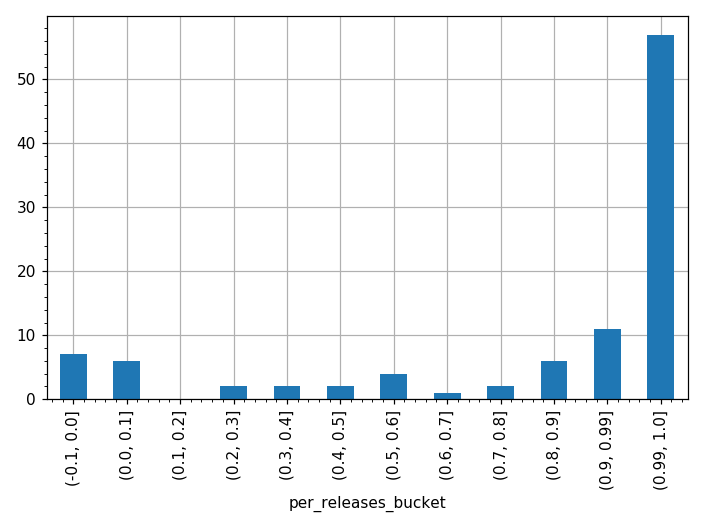

In [44]:
bins = np.concatenate((np.arange(-0.1,0.9,0.1), np.arange(0.9,1.01,0.01)), axis=None)
bins = np.concatenate((np.arange(-0.1,1,0.1), 0.99, 1), axis=None)
#bins = np.concatenate((np.arange(-0.1,1.1,0.1)), axis=None)
projects["per_releases_bucket"] = pd.cut(projects["per_releases"],bins=bins)
hist = projects.groupby("per_releases_bucket")["per_releases"].count()
print(hist)

fig, ax = plt.subplots()

hist.plot(kind="bar", ax=ax)
ax.minorticks_on()
ax.grid(True, which="major")
#ax.grid(True, which="minor")

ax.set_axisbelow(True)

fig.tight_layout()
fig.savefig("figs/hist_per_releases.png")

In [45]:
np.arange(-0.1,0,0.9,0.1)

TypeError: data type not understood

In [ ]:
bins = np.concatenate((np.arange(-0.1,0.9,0.1), np.arange(0.9,1.01,0.01)), axis=None)
bins = np.concatenate((np.arange(-0.1,1,0.1), 0.99, 1), axis=None)
#bins = np.concatenate((np.arange(-0.1,1.1,0.1)), axis=None)
projects["per_releases_bucket"] = pd.cut(projects["per_releases"],bins=bins)
hist = projects.groupby("per_releases_bucket")["per_releases"].count()
print(hist)

fig, ax = plt.subplots()

hist.plot(kind="bar", ax=ax)
ax.minorticks_on()
ax.grid(True, which="major")
#ax.grid(True, which="minor")

ax.set_axisbelow(True)

fig.tight_layout()
fig.savefig("figs/hist_per_releases.png")

## Peril 1

In [50]:
projects[projects["num_releases"] == 0][["stars","num_tags"]]

,stars,num_tags
name,,
freeCodeCamp/freeCodeCamp,308053.0,0
scikit-learn/scikit-learn,38880.0,92
mxgmn/WaveFunctionCollapse,13435.0,0
fastlane/fastlane,27826.0,997
huginn/huginn,26646.0,0
freeCodeCamp/devdocs,22083.0,0


## Promise: Tags can provide aditional information

In [129]:
tags[tags["annotated"] == True].shape

(17944, 2)

In [130]:
tags[tags["annotated"] == False].shape

(0, 2)

## Peril 1: Some projects do not use tags at all

In [ ]:
projects[projects.releases == 0].shape[0] / projects.shape[0]

In [ ]:
list(projects[projects.tags == 0].index)

In [ ]:
list(projects[projects.releases == 0].index)

## Release prefixes

## Peril - Different tags can reference the same release

In [98]:
release_clones = releases.groupby(["project", "head_commit"]).count()
release_clones = release_clones[release_clones.data > 1].copy()
release_clones.describe()

,data,prefix,time,start_development,length,duplicated
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,2.750487,2.750487,2.750487,2.750487,2.750487,2.750487
std,2.315902,2.315902,2.315902,2.315902,2.315902,2.315902
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000


In [92]:
releases["duplicated"] = False
releases.loc[(releases.index.get_level_values(0).isin(release_clones.index.get_level_values(0))) & (releases["head_commit"].isin(release_clones.index.get_level_values(1))), "duplicated"] = True


In [99]:
releases[releases["duplicated"] == True]

data  \
project                   name                                                           
facebook/create-react-app babel-preset-react-app@0.2.1    babel-preset-react-app@0.2.1   
                          create-react-app@0.5.0                create-react-app@0.5.0   
                          eslint-config-react-app@0.2.1  eslint-config-react-app@0.2.1   
                          react-dev-utils@0.1.0                  react-dev-utils@0.1.0   
                          react-scripts@0.5.0                      react-scripts@0.5.0   
...                                                                                ...   
syncthing/syncthing       v1.0.1                                                v1.0.1   
                          v1.1.0-rc.2                                      v1.1.0-rc.2   
                          v1.1.0                                                v1.1.0   
                          v1.1.1-rc.2                                      v1.1.1-rc.2   
                          v1.1.1                                                v1.1.1   

                                                                           prefix  \
project                   name                                                      
facebook/create-react-app babel-preset-react-app@0.2.1    babel-preset-react-app@   
                          create-react-app@0.5.0                create-react-app@   
                          eslint-config-react-app@0.2.1  eslint-config-react-app@   
                          react-dev-utils@0.1.0                  react-dev-utils@   
                          react-scripts@0.5.0                      react-scripts@   
...                                                                           ...   
syncthing/syncthing       v1.0.1                                                v   
                          v1.1.0-rc.2                                           v   
                          v1.1.0                                                v   
                          v1.1.1-rc.2                                           v   
                          v1.1.1                                                v   

                                                                                      head_commit  \
project                   name                                                                      
facebook/create-react-app babel-preset-react-app@0.2.1   7ac8777ed1cebec6084a03e84272cfd21128b356   
                          create-react-app@0.5.0         7ac8777ed1cebec6084a03e84272cfd21128b356   
                          eslint-config-react-app@0.2.1  7ac8777ed1cebec6084a03e84272cfd21128b356   
                          react-dev-utils@0.1.0          7ac8777ed1cebec6084a03e84272cfd21128b356   
                          react-scripts@0.5.0            7ac8777ed1cebec6084a03e84272cfd21128b356   
...                                                                                           ...   
syncthing/syncthing       v1.0.1                         1e69997ecdbf87ceaad76bd0149d98f560f4fdb5   
                          v1.1.0-rc.2                    f0f79a3e3e861b79da2b09f563e9d373255419f0   
                          v1.1.0                         f0f79a3e3e861b79da2b09f563e9d373255419f0   
                          v1.1.1-rc.2                    e4ab9d3312dfd768e269f5a7ed75eb9cfe50bffb   
                          v1.1.1                         e4ab9d3312dfd768e269f5a7ed75eb9cfe50bffb   

                                                                              time  \
project                   name                                                       
facebook/create-react-app babel-preset-react-app@0.2.1   2016-09-23 22:31:36+01:00   
                          create-react-app@0.5.0         2016-09-23 22:31:36+01:00   
                          eslint-config-react-app@0.2.1  2016-09-23 22:31:36+01:00   
                          react-dev-utils@0.1.0          2016

In [106]:
pd.DataFrame(release_clones.index.get_level_values(0).unique()).shape

(35, 1)

In [109]:
release_clones[release_clones.prefix == release_clones.prefix.max()]

,,data,prefix,time,start_development,length,duplicated
project,head_commit,,,,,,
apple/swift,f4134ebef606f675bd372db74cd6db32d30c6178,29,29,29,29,29,29


In [112]:
releases[releases.head_commit == "f4134ebef606f675bd372db74cd6db32d30c6178"]

data  \
project     name                                                                                       
apple/swift swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-25-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-25-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-26-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-26-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-27-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-27-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-28-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-28-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-01-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-01-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-02-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-02-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-03-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-03-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-05-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-05-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-06-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-06-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-07-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-07-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-08-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-08-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-09-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-09-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-10-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-10-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-11-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-11-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-12-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-12-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-13-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-13-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-14-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-14-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-15-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-15-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-16-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-16-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-17-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-17-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-18-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-18-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-20-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-20-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-21-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-21-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-22-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-22-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-23-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-23-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-25-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-25-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-26-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-26-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-29-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-29-a   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-30-a  swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-30-a   

                                                         prefix  \
project     name                                                  
apple/swift swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-25-a  swift-   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-26-a  swift-   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-27-a  swift-   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-09-28-a  swift-   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-01-a  swift-   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-02-a  swift-   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-03-a  swift-   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-05-a  swift-   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-06-a  swift-   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-07-a  swift-   
            swift-4.2-DEVELOPMENT-SNAPSHOT-2018-10-08-a  swift-   


In [115]:
release_clones.groupby(["project"]).count()

,data,prefix,time,start_development,length,duplicated
project,,,,,,
PHPMailer/PHPMailer,5,5,5,5,5,5
Wox-launcher/Wox,2,2,2,2,2,2
angular/angular.js,1,1,1,1,1,1
ant-design/ant-design,1,1,1,1,1,1
antirez/redis,5,5,5,5,5,5
apple/swift,68,68,68,68,68,68
aspnet/AspNetCore,4,4,4,4,4,4
bilibili/ijkplayer,1,1,1,1,1,1
bitcoin/bitcoin,16,16,16,16,16,16


In [114]:
release_clones.groupby(["project"]).sum()

,data,prefix,time,start_development,length,duplicated
project,,,,,,
PHPMailer/PHPMailer,10,10,10,10,10,10
Wox-launcher/Wox,4,4,4,4,4,4
angular/angular.js,2,2,2,2,2,2
ant-design/ant-design,2,2,2,2,2,2
antirez/redis,10,10,10,10,10,10
apple/swift,292,292,292,292,292,292
aspnet/AspNetCore,11,11,11,11,11,11
bilibili/ijkplayer,2,2,2,2,2,2
bitcoin/bitcoin,33,33,33,33,33,33


In [116]:
release_clones.groupby(["project"]).mean()

,data,prefix,time,start_development,length,duplicated
project,,,,,,
PHPMailer/PHPMailer,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Wox-launcher/Wox,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
angular/angular.js,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
ant-design/ant-design,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
antirez/redis,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
apple/swift,4.294118,4.294118,4.294118,4.294118,4.294118,4.294118
aspnet/AspNetCore,2.750000,2.750000,2.750000,2.750000,2.750000,2.750000
bilibili/ijkplayer,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
bitcoin/bitcoin,2.062500,2.062500,2.062500,2.062500,2.062500,2.062500


# Others

In [ ]:
projects[projects.percent_releases < 1][["tags","releases","percent_releases"]]

In [ ]:
project_df["created_at"] = pd.to_datetime(project_df["created_at"])

In [ ]:
project_df["n_tags"] = project_df["data"].apply(lambda project: len(project.tags))
project_df["n_releases"] = 0
project_df["p_releases"] = 0
project_df["n_releases"] = project_df["data"].apply(lambda project: len(project.releases))
project_df.loc[project_df["n_tags"] > 0,"p_releases"] = project_df["n_releases"]/project_df["n_tags"]

In [ ]:
project_df.loc[(project_df.n_releases < 5), "discarded_by"] = "few releases"
project_df.loc[(project_df.p_releases < 0.85), "discarded_by"] = "nom semantic"
project_df.loc[(project_df.created_at > "2018-10-01"), "discarded_by"] = "too young"
project_df.loc[(project_df.stars < 1000), "discarded_by"] = "few stars"

In [ ]:
project_df[(project_df.created_at > "2018-10-01")]

In [ ]:
summary = pd.DataFrame()
summary["n_projects"] = project_df[(project_df.discarded_by.isnull())].groupby(["language"])["n_releases"].count()
summary["older_project_birth"] = project_df[(project_df.discarded_by.isnull())].groupby(["language"])["created_at"].min()
summary["younger_project_birth"] = project_df[(project_df.discarded_by.isnull())].groupby(["language"])["created_at"].max()
summary["min_stars"] = project_df[(project_df.discarded_by.isnull())].groupby(["language"])["stars"].min()
summary["max_stars"] = project_df[(project_df.discarded_by.isnull())].groupby(["language"])["stars"].max()
summary["min_releases"] = project_df[(project_df.discarded_by.isnull())].groupby(["language"])["n_releases"].min()
summary["max_releases"] = project_df[(project_df.discarded_by.isnull())].groupby(["language"])["n_releases"].max()
summary["mean_releases"] = project_df[(project_df.discarded_by.isnull())].groupby(["language"])["n_releases"].mean().round(0)
summary["std_deviation_releases"] = project_df[(project_df.discarded_by.isnull())].groupby(["language"])["n_releases"].std().round(0)
summary["total_releases"] = project_df[(project_df.discarded_by.isnull())].groupby(["language"])["n_releases"].sum()
summary

In [ ]:
summary.total_releases.sum()

In [ ]:
project_df[(project_df.discarded_by.notnull()) & (project_df.language == "Go")].sort_values(by=["n_releases"], ascending=False)

In [ ]:
project_df[(project_df.n_tags < 5)].sort_values(by=["n_releases"], ascending=False)

In [ ]:
project_df[project_df.p_releases > 0.85].groupby("language").count()

In [ ]:
project_df[(project_df.n_tags < 10)].head(20)

In [ ]:
project_df[(project_df.p_releases < 0.85) & (project_df.discarded_by.isnull()) & (project_df.n_tags > 0)].head(20)

In [ ]:
for name,project_data in projects_data.items():
    if "discarded_by" in project_data:
        continue
    project = project_data["data"]
    tags = project.tags
    nom_release_tags = [tag for tag in project.tags if not tag.release or tag.name.startswith("zone") or tag.name.startswith("ngcontainer")]
    if len(tags) > 0:
        percent_releases = round(100*(1-len(nom_release_tags)/len(tags)),2)
    else:
        percent_releases = 0
    project_data["percent_releases"] = percent_releases
    
    prefixes = []
    for release in project.releases:
        if release.prefix not in prefixes:
            prefixes.append(release.prefix)

    print(f"{project.name:30} {percent_releases:10} {len(project.releases):10}/{len(project.tags)}")
    print("  Prefixes:")
    for prefix in prefixes:
         print(f"    - {str(prefix):30}")

    print("  Non releases:")            
    for tag in tags:
        if not tag.release:
           print(f"    - {tag.name}")
#        print(f"-- {tag.name:30} {tag.release != None}")
    print("---")





In [ ]:
f_releases = []
index = 0
last_project = None
for name,project_data in projects_data.items():
    if "percent_releases" in project_data and project_data["percent_releases"] > 90:
        project = project_data["data"]
        feature_releases = project.get_releases(skip_patches=True, skip_pre=True)
        feature_releases = sorted(feature_releases, key=lambda r: r.version)
        last_release = None
        for release in feature_releases:
            if release.patches:
                last_patch = release.patches[-1]
                maintenance_length = last_patch.time - release.time
                num_patches = len(release.patches)
            else:
                maintenance_length = pd.to_timedelta(0)
                last_patch = None
                num_patches = 0
            if release.pre_releases:
                first_pre_release = release.pre_releases[0]
                stage_length = release.time - first_pre_release.time 
                num_pre_releases = len(release.pre_releases)
            else:
                first_pre_release = None
                stage_length = pd.to_timedelta(0)
                num_pre_releases = 0

            if last_release and last_release.major != release.major:
                f_releases[index-1]["is_last_minor"] = True
            last_release = release
            
            if last_project and last_project != name:
                f_releases.pop()
                index -= 1
            last_project = name
            index += 1

            f_releases.append({
                "project": project.name,
                "release": release.name,
                "version": release.version,
                "is_last_minor": False,
                "time": pd.to_datetime(release.time, utc=True),
                "developtment_length": release.length,
                "last_patch": last_patch, 
                "last_patch_time": pd.to_datetime(last_patch.time, utc=True) if last_patch else None, 
                "maintenance_length": maintenance_length,
                "n_patches": num_patches,
                
                #"num_pre_releases": num_pre_releases,
                #"num_patches": num_patches,
                #"first_pre_release": first_pre_release, 
                #"stage_length": stage_length
            })

f_releases = pd.DataFrame(f_releases)    
f_releases = f_releases.sort_values(by=["project", "version"])

f_releases["maintenance_secs"] = f_releases["maintenance_length"].dt.total_seconds()
f_releases["time"] = f_releases["time"].dt.tz_convert(None)
f_releases["last_patch_time"] = f_releases["last_patch_time"].dt.tz_convert(None)

# remove releases sem manutenção
# f_releases = f_releases[f_releases.maintenance_length > pd.to_timedelta(0)].copy()

f_releases.to_excel("feature_releases_ds.xlsx")
f_releases.head(200)

In [ ]:
fig = plt.figure()                                                                                                                                                                                                                                                             
ax = fig.add_subplot(111)

f_releases.boxplot("maintenance_length", by="is_last_minor", ax=ax)

def timeTicks(x, pos):
    return str(pd.to_timedelta(x))
    #d = datetime.timedelta(seconds=x)
    #return str(d)
    #return x / 60 / 60 / 24
formatter = matplotlib.ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
ax.yaxis.set_major_formatter(formatter)

plt.suptitle("")
plt.tight_layout()

## Statistical Test

## Analise pareada por Projeto


In [ ]:
gr = f_releases.groupby(["project","is_last_minor"]).mean()

In [ ]:
gr.shape

In [ ]:
(gr.groupby(level=[0]).size() == 2)

In [ ]:
# gr = gr.drop(index="akveo/ngx-admin")
gr = gr.drop(index="apache/dubbo")
gr = gr.drop(index="facebook/react-native")

In [ ]:
gr.to_excel("pareado.xlsx")

In [ ]:
gr.shape

In [ ]:
a = gr.xs(True, level=1)["maintenance_secs"]

In [ ]:
b = gr.xs(False, level=1)["maintenance_secs"]

In [ ]:
wilcoxon(a,b)

## Análise de todas as releases

In [ ]:
a = f_releases[f_releases["is_last_minor"] == True]["maintenance_secs"]

In [ ]:
b = f_releases[f_releases["is_last_minor"] == False]["maintenance_secs"]

In [ ]:
ranksums(a,b)

## Análise intra-projetos

In [ ]:
intr_project_ds = pd.DataFrame()
intr_project_ds["project"] = f_releases["project"].unique()
intr_project_ds["n_feature_release"] = intr_project_ds["project"].apply(lambda project_name: len(f_releases[f_releases["project"] == project_name]))
intr_project_ds["n_last_minor"] = intr_project_ds["project"].apply(lambda project_name: len(f_releases[(f_releases["project"] == project_name) & (f_releases["is_last_minor"] == True)]))
intr_project_ds = intr_project_ds[intr_project_ds.n_last_minor > 0]
intr_project_ds["p-value"] = intr_project_ds["project"].apply(lambda project_name: ranksums(
    f_releases[(f_releases["is_last_minor"] == True) & (f_releases["project"] == project_name)]["maintenance_secs"],
    f_releases[(f_releases["is_last_minor"] == False) & (f_releases["project"] == project_name)]["maintenance_secs"]
)[1])
intr_project_ds["h0"] = intr_project_ds["p-value"] >= 0.05
intr_project_ds.to_excel("intr_project_ds.xlsx")
intr_project_ds

In [ ]:
project_ds.head()

In [ ]:
project_ds = f_releases.groupby(["project"])["project"]
a

In [ ]:
f_releases.release.count() + f_releases.num_patches.sum() + f_releases.num_pre_releases.sum()

In [ ]:
gr.to_csv("gr_releases.csv", sep=";")

In [ ]:
f_releases.to_csv("releases.csv", sep=";")

In [ ]:
f_releases[f_releases.is_last_minor == False]

In [ ]:
for project in projects.values():
    feature_releases = project.get_releases(skip_patches=True, skip_pre=True)
    print(f"{project.name:20}")
    print(f"{'release':10} {'time':28} {'length':20} {'last_patch':10} {'maintenance':20}")
    for release in feature_releases:
        if release.name.startswith("ng") or release.name.startswith("zone"):
            continue
        if release.patches:
            last_patch = release.patches[-1]
            maintenance = last_patch.time - release.time
        else:
            maintenance = None
            last_patch = None
        if release.pre_releases:
            first_pre = release.pre_releases[0]
        else:
            first_pre = None
          
        print(f"{release.name:10} {str(release.time):28} {str(release.length):20} {str(first_pre):15} {str(last_patch):10} {str(maintenance):20}")

In [ ]:
tags = project.tags
nom_release_tags = [tag for tag in project.tags if not tag.release or tag.name.startswith("zone") or tag.name.startswith("ngcontainer")]
percent_releases = round(100*(1-len(nom_release_tags)/len(tags)),2)
percent_releases

In [ ]:
nom_release_tags

In [ ]:
feature_releases = project.get_releases(skip_patches=True, skip_pre=True)
print(f"{'release':10} {'time':28} {'length':20} {'last_patch':10} {'maintenance':20}")
for release in feature_releases:
    if release.name.startswith("ng") or release.name.startswith("zone"):
        continue
    if release.patches:
        last_patch = release.patches[-1]
        maintenance = last_patch.time - release.time
    else:
        last_patch = None
    print(f"{release.name:10} {str(release.time):28} {str(release.length):20} {str(last_patch):10} {str(maintenance):20}")

In [ ]:
release.patches[-1]

In [ ]:
releases = project.get_releases(skip_pre=True)
for release in releases:
    if release.is_patch():
        print(f"{release.name:20} {str(release.time):30} {str(release.length):10}")